## A Comparision of XGBoost and TensorFlow Boosted Trees

April 17, 2019

Ewen Wang wolfgangwong2012@gmail.com

The gradient boosting decision trees algorithm is one of the best (I double it's the best, however) machine learning algorithm for tabular data in the field of supervised machine learning. Generally speaking, TensorFlow is used in the deep learning field with unstructured data, like images, videos, audios, and text. 

XGBoost is a powerful tool in not only competition like Kaggle, but also in industry for its high performance and wide-supported platforms. While TensorFlow got its crown in deep learning for its attractive philosophy, beautiful architecture, strong community, and vision to the future. 

TensorFlow supports boosted trees models but never got much attention in the world of machine learning. I just wonder if we could build our machine learning models basically with TensorFlow to keep consistency of our products, maybe at a cost of lower performance compared to XGBoost. 

Here comes this experiment.

**Note:** TensorFlow 2.0 Alpha is used in the experiment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(123)

In [2]:
# load dataset
# dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
# dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
dftrain = pd.read_csv('/Users/ewenwang/Documents/practice_data/titanic_train.csv')
dfeval = pd.read_csv('/Users/ewenwang/Documents/practice_data/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

### exploratory data analysis

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

In [6]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

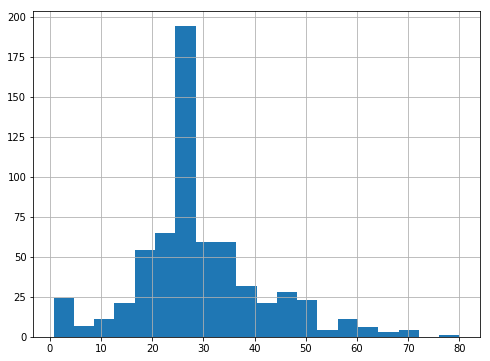

In [7]:
plt.rcParams["figure.figsize"] = (8,6)

# plt.style.use('seaborn-whitegrid')

dftrain.age.hist(bins=20)

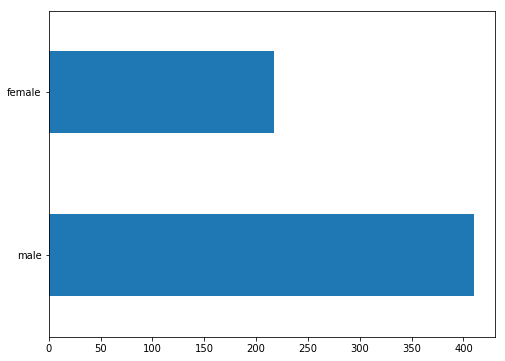

In [8]:
plt.figure(figsize=(8, 6))
dftrain.sex.value_counts().plot(kind='barh')

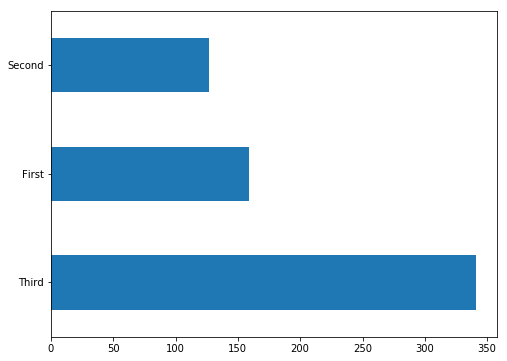

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

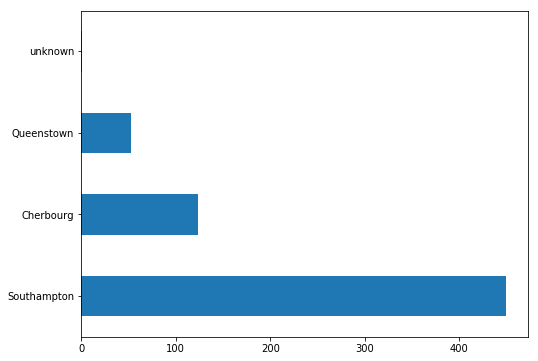

In [10]:
dftrain.embark_town.value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

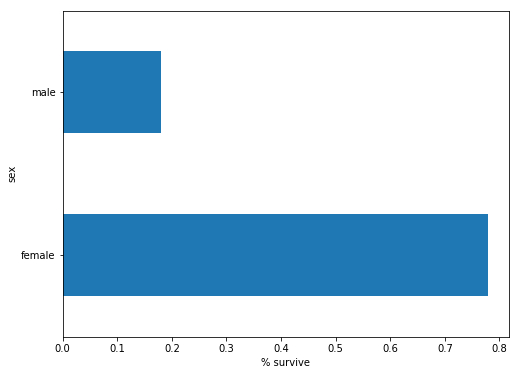

In [11]:
ax = (pd.concat([dftrain, y_train], axis=1)\
     .groupby('sex')
     .survived
     .mean()
     .plot(kind='barh'))
ax.set_xlabel('% survive')

### xgboost

In [12]:
# preprocessing

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def preprocessing(data):
    
    # one-hot encoding
    for col in CATEGORICAL_COLUMNS:
        # use pd.concat to join the new columns with your original dataframe
        data = pd.concat([data, pd.get_dummies(data[col], prefix=str(col), dummy_na=True)], axis=1)

        # now drop the original 'country' column (you don't need it anymore)
        data.drop([col], axis=1, inplace=True)
    
    return data

dtrain = preprocessing(dftrain)
dtest = preprocessing(dfeval)

# note!
dtest = dtest.drop('parch_6.0', axis=1)
dtrain = dtrain.drop('deck_G', axis=1)

import xgboost as xgb

dtrain = xgb.DMatrix(dtrain, label=y_train)
dtest = xgb.DMatrix(dtest, label=y_eval)

In [13]:
n_rounds = 500
early_stopping = 20
verbose = 10
seed = 123

params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'eval_metric': 'aucpr',
    'eta': 0.01,
    'max_depth': 3,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
}

cvr = xgb.cv(params=params,
    dtrain=dtrain,
    num_boost_round=n_rounds,
    nfold=10,
    stratified=True,
    metrics='aucpr',
    maximize=True,
    early_stopping_rounds=early_stopping,
    verbose_eval=verbose,
    seed=seed)

bst_rounds = cvr.shape[0]
print(bst_rounds)

[0]	train-aucpr:0.822775+0.00859323	test-aucpr:0.798681+0.0781413
[10]	train-aucpr:0.864542+0.00720843	test-aucpr:0.834363+0.0540851
[20]	train-aucpr:0.86736+0.00557212	test-aucpr:0.831284+0.0585028
[30]	train-aucpr:0.869955+0.00472621	test-aucpr:0.839254+0.0501287
[40]	train-aucpr:0.870689+0.00470618	test-aucpr:0.838009+0.0508688
31


In [14]:
bst = xgb.train(params=params,
    dtrain=dtrain,
    evals=[(dtrain, 'train')],
    num_boost_round=bst_rounds,
    verbose_eval=verbose)

bst.eval(dtest)

[0]	train-aucpr:0.831954
[10]	train-aucpr:0.86733
[20]	train-aucpr:0.869196
[30]	train-aucpr:0.868652


'[0]\teval-aucpr:0.820446'

### tensorflow boosted trees

In [15]:
fc = tf.feature_column

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

# fc.indicator_column:
#        Represents multi-hot representation of given categorical column.

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(key=feature_name, vocabulary_list=vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

# fc.numeric_column:
#        Represents real valued or numerical features.

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(key=feature_name))

In [16]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town',

In [17]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    dataset = dataset.repeat(n_epochs)    # For training, cycle thru dataset as many times as need (n_epochs=None).   
    dataset = dataset.batch(NUM_EXAMPLES) # In memory training doesn't use batching.
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# train model
linear_est.train(train_input_fn, max_steps=100)

# evaluation
results = linear_est.evaluate(eval_input_fn)
print('accuracy: ', results['accuracy'])
print('dummy model: ', results['accuracy_baseline'])

W0418 11:03:00.975817 4571866560 estimator.py:1799] Using temporary folder as model directory: /var/folders/qj/j182jn510qx8l3wqb64zvjfc0000gn/T/tmp3n38h3rw
W0418 11:03:01.001063 4571866560 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0418 11:03:01.123698 4571866560 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0418 11:03:01.145018 4571866560 deprec

accuracy:  0.7651515
dummy model:  0.625


In [19]:
help(tf.estimator.BoostedTreesClassifier)

Help on class BoostedTreesClassifier in module tensorflow_estimator.python.estimator.canned.boosted_trees:

class BoostedTreesClassifier(_BoostedTreesBase)
 |  BoostedTreesClassifier(feature_columns, n_batches_per_layer, model_dir=None, n_classes=<object object at 0x125355ba0>, weight_column=None, label_vocabulary=None, n_trees=100, max_depth=6, learning_rate=0.1, l1_regularization=0.0, l2_regularization=0.0, tree_complexity=0.0, min_node_weight=0.0, config=None, center_bias=False, pruning_mode='none', quantile_sketch_epsilon=0.01, train_in_memory=False)
 |  
 |  A Classifier for Tensorflow Boosted Trees models.
 |  
 |  @compatibility(eager)
 |  Estimators can be used while eager execution is enabled. Note that `input_fn`
 |  and all hooks are executed inside a graph context, so they have to be written
 |  to be compatible with graph mode. Note that `input_fn` code using `tf.data`
 |  generally works in both graph and eager modes.
 |  @end_compatibility
 |  
 |  Method resolution orde

In [20]:
params = {
    'n_batches_per_layer': 1,
    'n_trees': 50,
    'max_depth': 3,
    'learning_rate': 0.01,
    'l1_regularization': 0.0,
    'l2_regularization': 0.0,
    'tree_complexity': 0.0,
    'min_node_weight': 0.0,
    'center_bias': True,
    'pruning_mode': 'none',
    'quantile_sketch_epsilon': 0.01
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

# n_batches = 1
# est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches)

est.train(train_input_fn, max_steps=100)

results = est.evaluate(eval_input_fn)
# print('accuracy: ', results['accuracy'])
# print('dummy model: ', results['accuracy_baseline'])

pd.Series(results).to_frame()

W0418 11:03:07.094273 4571866560 estimator.py:1799] Using temporary folder as model directory: /var/folders/qj/j182jn510qx8l3wqb64zvjfc0000gn/T/tmpdjbagt0h
W0418 11:03:07.156394 4571866560 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column.py:2121: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0418 11:03:07.159886 4571866560 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column.py:2121: IndicatorColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _Feat

,0
accuracy,0.776515
accuracy_baseline,0.625000
auc,0.830364
auc_precision_recall,0.807346
average_loss,0.502793
label/mean,0.375000
loss,0.502793
precision,0.732558
prediction/mean,0.385597
recall,0.636364


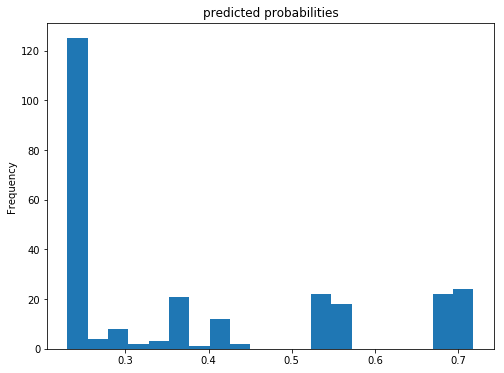

In [21]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

(0, 1.05)

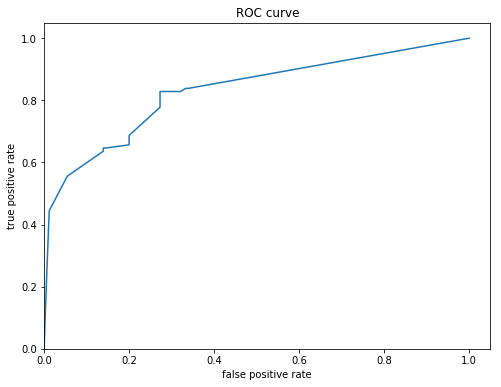

In [22]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

In [23]:
from sklearn.metrics import average_precision_score

average_precision_score(y_eval, probs)

0.7711868065488886

You may find similar experiments from [Gradient Boosting in TensorFlow vs XGBoost](https://nicolovaligi.com/gradient-boosting-tensorflow-xgboost.html).